# Dense Neural Network Regressor

In [1]:
import feather
import pandas as pd
import category_encoders as ce
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
path_train = './input/train_final.feather'
path_test = './input/test_final.feather'

# Import des dataframes

In [2]:
df_train = feather.read_dataframe(path_train)
df_test = feather.read_dataframe(path_test)

In [3]:
from sklearn.utils import shuffle
df_train = shuffle(df_train)

# Split des dataframes

Nous séparons les variables des labels pour chaque dataset

In [4]:
y_train = df_train.pop('Rating')

In [5]:
X_train = df_train

In [6]:
y_test = df_test.pop('Rating')

In [7]:
X_test = df_test

# Encoding

Il est nécessaire de retravailler les différentes features afin d'alimenter le réseau. Nous récupérons dans un premier temps le nom des colonnes numériques d'une part, et celu des colonnes catégorielles d'autre part.

In [8]:
def divide_features_by_type(X_train):
    cat_cols = list(X_train.select_dtypes(include=['object']).columns)
    num_cols = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
    return cat_cols, num_cols

In [9]:
cat_cols, num_cols = divide_features_by_type(X_train)

## Normalisation des variables numériques

Pour faciliter l'entraînement du réseau, nous normalisons les données numériques par centrage et réduction. Ce traitement permet de mettre toutes les variables numériques à même échelle.

In [10]:
def normalize(df, num_cols):
    for col in num_cols:
         df[col] = normalize_column(df[col].values)
    return df

In [11]:
def normalize_column(col):
    return (col - np.mean(col)) / np.std(col)

In [12]:
X_train = normalize(X_train,num_cols)

In [13]:
X_test = normalize(X_test,num_cols)

## Encoding des variables catégorielles

Nous remarquons que les deux encodages binaires et catboost sont équivalents, il n' a pas d'amélioration des résultats lesconcernant et ilspeuvent être interchangé pour réaliser l'entraînement de notre réseau.

## Encoding Binaire

Nous encodons nos variables catégorielles avec un binaryEncoder, ce qui permet de transformer les variables catégorielles en valeurs booléennes. n colonnes permettent d'encoder 2^n valeurs possibles

In [ ]:
def encode_with_binary(X_train, y_train, X_test, cat_cols):
    encoder = ce.BinaryEncoder(verbose = 3, cols = cat_cols, return_df=True)
    encoder.fit(X_train, y_train)
    X_train_cat = encoder.transform(X_train)
    X_test_cat = encoder.transform(X_test)
    return X_train_cat, X_test_cat
    

In [ ]:
X_train, X_test = encode_with_binary(X_train, y_train, X_test, cat_cols)

In [14]:
X_train.head(10)

,Artist,Track,User,Time,GENDER,AGE,WORKING,REGION,MUSIC,LIST_OWN,LIST_BACK,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,HEARD_OF,OWN_ARTIST_MUSIC,LIKE_ARTIST,Uninspired,Sophisticated,Aggressive,Edgy,Sociable,Laid back,Wholesome,Uplifting,Intriguing,Legendary,Free,Thoughtful,Outspoken,Serious,Good lyrics,Unattractive,Confident,Old,Youthful,Boring,Current,Colourful,Stylish,Cheap,Irrelevant,Heartfelt,Calm,Pioneer,Outgoing,Inspiring,Beautiful,Fun,Authentic,Credible,Way out,Cool,Catchy,Sensitive,Mainstream,Superficial,Annoying,Dark,Passionate,Not authentic,Good Lyrics,Background,Timeless,Depressing,Original,Talented,Worldly,Distinctive,Approachable,Genius,Trendsetter,Noisy,Upbeat,Relatable,Energetic,Exciting,Emotional,Nostalgic,None of these,Progressive,Sexy,Over,Rebellious,Fake,Cheesy,Popular,Superstar,Relaxed,Intrusive,Unoriginal,Dated,Iconic,Unapproachable,Classic,Playful,Arrogant,Warm,Soulful
18122,0.951320,0.115510,0.087691,1.138465,Female,1.668713,Employed part-time less than 8 hours per week,South,I like music but it does not feature heavily i...,-0.383700,-0.573996,-1.388995,-0.278903,-0.089715,0.517324,0.691874,-0.960923,-0.749958,2.129347,1.022558,-0.355100,-0.387838,-0.835743,0.183845,-0.054458,-1.123855,-0.131895,-1.707870,-1.454253,-1.396215,Never heard of,,0.024373,-0.147401,-0.112964,-0.193592,-0.324189,-0.113803,-0.173009,-0.042252,-0.133495,-0.1371,-0.126675,-0.220219,-0.333993,-0.101856,-0.213114,-0.389745,-0.236033,-0.377037,-0.083573,-0.3315,-0.384802,-0.415218,-0.150767,-0.321587,-0.174123,-0.107578,-0.153525,-0.388289,-0.076401,-0.203241,-0.244501,-0.353916,-0.333171,-0.390432,-0.338837,-0.095243,-0.412517,-0.490080,-0.264240,-0.162682,-0.197246,-0.206802,-0.100149,-0.308024,-0.090526,-0.205247,-0.123948,-0.338739,-0.279225,-0.431863,-0.446225,-0.064841,-0.505982,-0.318694,-0.120769,-0.203064,-0.239331,-0.327634,-0.108832,-0.378662,-0.139587,-0.183956,-0.103274,3.362669,-0.091193,-0.185204,-0.138274,-0.131136,-0.160806,-0.228332,-0.15141,-0.083733,-0.146955,-0.076049,-0.277124,-0.276722,-0.113024,-0.123008,-0.337547,-0.222294,-0.169236,-0.323227,-0.111145
88611,1.572575,1.365051,1.379675,0.051563,Male,-0.144553,Employed 8-29 hours per week,Midlands,I like music but it does not feature heavily i...,-0.768520,-0.248388,-1.388995,0.630638,-1.571144,-1.139344,-1.038147,-1.201285,-0.990085,-0.840416,0.116674,-1.816254,0.001465,-1.731424,-1.397007,-1.011908,-1.123855,-1.121576,0.441314,-1.454253,-1.308924,Heard of and listened to music EVER,Own none of their music,-0.915137,-0.147401,-0.112964,-0.193592,-0.324189,-0.113803,-0.173009,-0.042252,-0.133495,-0.1371,-0.126675,-0.220219,2.994075,-0.101856,-0.213114,-0.389745,-0.236033,2.652261,-0.083573,-0.3315,-0.384802,2.408371,-0.150767,3.109581,-0.174123,-0.107578,-0.153525,2.575404,-0.076401,-0.203241,-0.244501,-0.353916,-0.333171,-0.390432,-0.338837,-0.095243,2.424141,2.040484,3.784437,-0.162682,-0.197246,-0.206802,-0.100149,-0.308024,-0.090526,-0.205247,-0.123948,-0.338739,-0.279225,2.315549,2.241022,-0.064841,1.976354,-0.318694,-0.120769,-0.203064,-0.239331,-0.327634,-0.108832,-0.378662,-0.139587,-0.183956,-0.103274,-0.297383,-0.091193,-0.185204,-0.138274,-0.131136,-0.160806,-0.228332,-0.15141,-0.083733,-0.146955,-0.076049,-0.277124,-0.276722,-0.113024,-0.123008,-0.337547,-0.222294,-0.169236,-0.323227,-0.111145
93378,0.330065,-0.277202,-0.305758,0.983193,Female,0.244004,Part-time student,South,Music means a lot to me and is a passion of mine,-0.383700,0.077220,-0.604160,-0.452148,0.806939,1.476447,1.401626,-0.960923,0.770841,-0.628290,0.758341,0.497240,0.001465,0.385641,-0.086056,0.145011,-0.211788,-0.131895,0.441314,0.339381,1.658978,Never heard of,,0.024373,-0.147401,-0.112964,-0.193592,-0.324189,-0.113803,-0.173009,-0.042252,-0.133495,-0.1371,-0.126675,-0.220219,-0.333993,-0.101856,-0.213114,-0.389745,-0.236033,-0.377037,-0.083573,-0.3315,-0.384802,-0.415218,-0.150767,-0.321587,-0.174123,-0.107578,-0.153525,-0.388289,-0.076401,-0.203241,-0.

In [15]:
X_test.head(10)

,Artist,Track,User,Time,GENDER,AGE,WORKING,REGION,MUSIC,LIST_OWN,LIST_BACK,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,HEARD_OF,OWN_ARTIST_MUSIC,LIKE_ARTIST,Uninspired,Sophisticated,Aggressive,Edgy,Sociable,Laid back,Wholesome,Uplifting,Intriguing,Legendary,Free,Thoughtful,Outspoken,Serious,Good lyrics,Unattractive,Confident,Old,Youthful,Boring,Current,Colourful,Stylish,Cheap,Irrelevant,Heartfelt,Calm,Pioneer,Outgoing,Inspiring,Beautiful,Fun,Authentic,Credible,Way out,Cool,Catchy,Sensitive,Mainstream,Superficial,Annoying,Dark,Passionate,Not authentic,Good Lyrics,Background,Timeless,Depressing,Original,Talented,Worldly,Distinctive,Approachable,Genius,Trendsetter,Noisy,Upbeat,Relatable,Energetic,Exciting,Emotional,Nostalgic,None of these,Progressive,Sexy,Over,Rebellious,Fake,Cheesy,Popular,Superstar,Relaxed,Intrusive,Unoriginal,Dated,Iconic,Unapproachable,Classic,Playful,Arrogant,Warm,Soulful
0,0.195787,-0.490426,-0.607228,0.833100,Male,0.309750,Employed 8-29 hours per week,Midlands,I like music but it does not feature heavily i...,-0.764728,-0.902770,0.109634,-0.062506,-0.121693,-1.366446,-1.216834,0.354356,0.539110,0.785345,0.035691,-0.237626,-0.386679,0.628002,0.076478,-0.166230,-1.200370,-1.125225,0.684538,0.384735,0.443386,Never heard of,,0.020474,-0.146696,-0.110225,-0.194823,-0.329502,-0.118547,-0.180287,-0.041538,-0.134749,-0.139858,-0.124717,-0.225167,-0.333637,-0.100453,-0.213215,-0.387961,-0.234182,-0.376670,-0.084253,3.007888,-0.385607,2.39636,-0.148942,-0.322839,-0.172215,-0.107736,-0.152618,-0.389948,-0.077792,-0.200611,-0.246941,-0.349981,-0.329799,2.563262,-0.340511,-0.099098,2.416674,2.056464,-0.268859,-0.16251,-0.19759,-0.202816,-0.099913,-0.304855,-0.089517,-0.206331,-0.130508,-0.333245,-0.276875,-0.435744,-0.447057,-0.068451,-0.506757,-0.320331,-0.121276,-0.204017,-0.240597,-0.329700,-0.108987,2.632771,-0.136874,-0.184706,-0.10596,-0.29795,-0.091157,-0.180835,-0.13887,-0.130087,-0.161563,-0.226269,-0.15189,-0.090415,-0.150974,-0.082481,-0.272692,-0.278922,-0.116928,-0.122173,-0.343073,-0.222491,-0.169008,-0.323589,-0.108113
1,0.886419,0.027414,0.170439,1.143478,Male,-0.208260,Employed 30+ hours a week,South,Music is important to me but not necessarily m...,0.009655,-0.902770,0.109634,-0.149289,0.620039,0.650708,-0.016591,0.555075,-0.063694,0.145366,0.186612,0.696880,0.391677,0.587304,0.850679,0.672486,1.228292,-0.131996,0.684538,0.384735,0.224044,Never heard of,,0.020474,-0.146696,-0.110225,-0.194823,-0.329502,-0.118547,-0.180287,-0.041538,-0.134749,-0.139858,-0.124717,-0.225167,-0.333637,-0.100453,-0.213215,-0.387961,-0.234182,-0.376670,-0.084253,3.007888,-0.385607,-0.41730,-0.148942,-0.322839,-0.172215,-0.107736,-0.152618,-0.389948,-0.077792,-0.200611,-0.246941,-0.349981,-0.329799,2.563262,-0.340511,-0.099098,2.416674,-0.486272,-0.268859,-0.16251,-0.19759,-0.202816,-0.099913,-0.304855,-0.089517,-0.206331,-0.130508,-0.333245,-0.276875,2.294927,-0.447057,-0.068451,-0.506757,-0.320331,-0.121276,-0.204017,-0.240597,-0.329700,-0.108987,-0.379828,-0.136874,-0.184706,-0.10596,-0.29795,-0.091157,-0.180835,-0.13887,-0.130087,-0.161563,-0.226269,-0.15189,-0.090415,-0.150974,-0.082481,-0.272692,-0.278922,-0.116928,-0.122173,-0.343073,-0.222491,-0.169008,-0.323589,-0.108113
2,-0.080466,-0.686848,-0.461865,0.833100,Female,1.410521,Retired from full-time employment (30+ hours p...,Midlands,I like music but it does not feature heavily i...,-0.764728,-0.577267,-1.652332,-0.062506,-1.058619,-1.234892,-1.305741,1.839677,-1.229117,-1.049263,0.790297,0.046789,0.867338,-0.104569,-1.665475,-1.963479,-1.399441,-1.305812,-1.869918,-1.821486,-1.574561,Never heard of,,0.020474,-0.146696,-0.110225,-0.194823,-0.329502,-0.118547,-0.180287,-0.041538,-0.134749,-0.139858,-0.124717,-0.225167,-0.333637,-0.100453,-0.213215,-0.387961,-0.234182,2.654844,-0.084253,-0.332459,-0.385607,2.39636,-0.148942,3.097517,-0.172215,-0.107736,-0.152618,-0.389948,-0.077792,-0.200611,-0.246941,-0.349981,-0.329799,-0.390128,-0.340511,-0.

## Encoding Catboost

In [16]:
#Nous réutilisons l'encoding mis en place pour le XgBoost
def encode_with_catboost(X_train, y_train, X_test):
    cat_cols = list(X_train.select_dtypes(include=['object']).columns)
    encoder = ce.CatBoostEncoder(verbose = 3, cols = cat_cols, return_df=True)
    encoder.fit(X_train, y_train)
    X_train_cat = encoder.transform(X_train)
    X_test_cat = encoder.transform(X_test)
    return X_train_cat, X_test_cat
    

In [17]:
X_train, X_test = encode_with_catboost(X_train, y_train, X_test)

In [18]:
#On normalise les colonnes encodées
X_train = normalize(X_train,cat_cols)

In [19]:
#On normalise les colonnes encodées
X_test = normalize(X_test,cat_cols)

In [20]:
X_train.head(5)

,Artist,Track,User,Time,GENDER,AGE,WORKING,REGION,MUSIC,LIST_OWN,LIST_BACK,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,HEARD_OF,OWN_ARTIST_MUSIC,LIKE_ARTIST,Uninspired,Sophisticated,Aggressive,Edgy,Sociable,Laid back,Wholesome,Uplifting,Intriguing,Legendary,Free,Thoughtful,Outspoken,Serious,Good lyrics,Unattractive,Confident,Old,Youthful,Boring,Current,Colourful,Stylish,Cheap,Irrelevant,Heartfelt,Calm,Pioneer,Outgoing,Inspiring,Beautiful,Fun,Authentic,Credible,Way out,Cool,Catchy,Sensitive,Mainstream,Superficial,Annoying,Dark,Passionate,Not authentic,Good Lyrics,Background,Timeless,Depressing,Original,Talented,Worldly,Distinctive,Approachable,Genius,Trendsetter,Noisy,Upbeat,Relatable,Energetic,Exciting,Emotional,Nostalgic,None of these,Progressive,Sexy,Over,Rebellious,Fake,Cheesy,Popular,Superstar,Relaxed,Intrusive,Unoriginal,Dated,Iconic,Unapproachable,Classic,Playful,Arrogant,Warm,Soulful
18122,0.951320,0.115510,0.087691,1.138465,1.004627,1.668713,-0.386736,-0.049048,-1.012596,-0.383700,-0.573996,-1.388995,-0.278903,-0.089715,0.517324,0.691874,-0.960923,-0.749958,2.129347,1.022558,-0.355100,-0.387838,-0.835743,0.183845,-0.054458,-1.123855,-0.131895,-1.707870,-1.454253,-1.396215,-0.707652,-0.477287,0.024373,-0.147401,-0.112964,-0.193592,-0.324189,-0.113803,-0.173009,-0.042252,-0.133495,-0.1371,-0.126675,-0.220219,-0.333993,-0.101856,-0.213114,-0.389745,-0.236033,-0.377037,-0.083573,-0.3315,-0.384802,-0.415218,-0.150767,-0.321587,-0.174123,-0.107578,-0.153525,-0.388289,-0.076401,-0.203241,-0.244501,-0.353916,-0.333171,-0.390432,-0.338837,-0.095243,-0.412517,-0.490080,-0.264240,-0.162682,-0.197246,-0.206802,-0.100149,-0.308024,-0.090526,-0.205247,-0.123948,-0.338739,-0.279225,-0.431863,-0.446225,-0.064841,-0.505982,-0.318694,-0.120769,-0.203064,-0.239331,-0.327634,-0.108832,-0.378662,-0.139587,-0.183956,-0.103274,3.362669,-0.091193,-0.185204,-0.138274,-0.131136,-0.160806,-0.228332,-0.15141,-0.083733,-0.146955,-0.076049,-0.277124,-0.276722,-0.113024,-0.123008,-0.337547,-0.222294,-0.169236,-0.323227,-0.111145
88611,1.572575,1.365051,1.379675,0.051563,-1.054696,-0.144553,-0.310852,-1.129914,-1.012596,-0.768520,-0.248388,-1.388995,0.630638,-1.571144,-1.139344,-1.038147,-1.201285,-0.990085,-0.840416,0.116674,-1.816254,0.001465,-1.731424,-1.397007,-1.011908,-1.123855,-1.121576,0.441314,-1.454253,-1.308924,0.758045,0.025799,-0.915137,-0.147401,-0.112964,-0.193592,-0.324189,-0.113803,-0.173009,-0.042252,-0.133495,-0.1371,-0.126675,-0.220219,2.994075,-0.101856,-0.213114,-0.389745,-0.236033,2.652261,-0.083573,-0.3315,-0.384802,2.408371,-0.150767,3.109581,-0.174123,-0.107578,-0.153525,2.575404,-0.076401,-0.203241,-0.244501,-0.353916,-0.333171,-0.390432,-0.338837,-0.095243,2.424141,2.040484,3.784437,-0.162682,-0.197246,-0.206802,-0.100149,-0.308024,-0.090526,-0.205247,-0.123948,-0.338739,-0.279225,2.315549,2.241022,-0.064841,1.976354,-0.318694,-0.120769,-0.203064,-0.239331,-0.327634,-0.108832,-0.378662,-0.139587,-0.183956,-0.103274,-0.297383,-0.091193,-0.185204,-0.138274,-0.131136,-0.160806,-0.228332,-0.15141,-0.083733,-0.146955,-0.076049,-0.277124,-0.276722,-0.113024,-0.123008,-0.337547,-0.222294,-0.169236,-0.323227,-0.111145
93378,0.330065,-0.277202,-0.305758,0.983193,1.004627,0.244004,-1.880031,-0.049048,0.851718,-0.383700,0.077220,-0.604160,-0.452148,0.806939,1.476447,1.401626,-0.960923,0.770841,-0.628290,0.758341,0.497240,0.001465,0.385641,-0.086056,0.145011,-0.211788,-0.131895,0.441314,0.339381,1.658978,-0.707652,-0.477287,0.024373,-0.147401,-0.112964,-0.193592,-0.324189,-0.113803,-0.173009,-0.042252,-0.133495,-0.1371,-0.126675,-0.220219,-0.333993,-0.101856,-0.213114,-0.389745,-0.236033,-0.377037,-0.083573,-0.3315,-0.384802,-0.415218,-0.150767,-0.321587,-0.174123,-0.107578,-0.153525,-0.388289,-0.076401,-0.203241,-0.244501,-0.353916,-0.333171,-0.390432,2.951275,-0.095243,-0.412517,-0.490080,-0.264240,6.146967,-0.197246,-0.206802,-0.100149,-0.308024,-0.090526,-0.205247,-0.123948,-0.338739,-0.279225,-0.431863,-0.4

# Root Mean Squared Error

Pour la régression, le callenge Kaggle demande d'évaluer la Root Mean Squared Error. La plupart des algorithmes permettent déjà d'utiliser la Mean Squared Error, il suffit de rajouter une racine carré à la fonction. Nous définissons à la fois la méthode permettant de calculer le résultat final et la méthode permettant de calculer la métrique pour le réseau Keras.

In [21]:
def compute_RMSE(y_true, y_pred):
    #la prédiction doit avoir un format entier
    tmp = []
    for el in y_pred:
        tmp.append(round(el))
    RMSE = np.sqrt(np.mean((y_true-tmp)**2))
    print("Root mean squared error: {}".format(RMSE))


In [22]:
from keras import backend
#Nous implémentons la fonction calculant la Root Mean Square Error pour pouvoir lutiliser comme métrique de notre réseau
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred-y_true), axis=0))

Using TensorFlow backend.


# Sequential Model - DNN regressor - Keras

Nous allons utiliser un modèle séquentiel du framework Keras avec un backend Tensorflow pour pouvoir entraîner directemen sur le CGU. Keras permet entre autre de construire des réseaux de neurones de type dense, soit un empilement linéaire de couches. Après plusieurs essais, nous fixons la valeurs des perparamètres suivants : 

In [23]:
learning_rate = 0.0001
epochs = 1000
batch_size = 25
#par defaut
initializer = 'glorot_uniform'

De même, nous définissons la structure du réseau avec une couche d'input de 15 neurones, une couche cachées de 15 et une couce d'ouput avec le résultat de la régression. Nous appliquons une régularization par dropout pour éviter le surapprentissage. Les hyperparamètres les plus performants sont : 
* L'initializer Xavier (ou Glorot) uniform pour l'initialisation des poids (par défaut dans keras)
* L'initialisation des biais à 0
* L'optimizer Adam pour l'ajustement des poids

Nous appliquons une loss MSE car nous effectuons une tâche de régression

In [24]:
#construction du modèle
def build_model(X_train, learning_rate, initializer):
    model = keras.Sequential([
        layers.Dense(15, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
        keras.layers.Dropout(0.2),
        layers.Dense(15, activation=tf.nn.relu),
        keras.layers.Dropout(0.2),
        layers.Dense(1)
    ])
    #L'optimizer permet d'ajuster les poids en fonction du résultat de la loss
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)


    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_squared_error', rmse])
    return model

In [25]:
#Construction du modèle
model = build_model(X_train, learning_rate, initializer)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


Afin de ne pas entraîner le modèle sur 1000 epoch, ce qui veut dire que l'on passe  1000 fois sur notre jeu de données d'apprentissage, nous définissons une procédure d'arrêt basée sur la valeur de la loss d'évaluation. Si celle-ci ne baisse pas 5 epoc, le modèle arrête d'apprendre car il est en surapprentissage

In [26]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                1740      
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                240       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 1,996
Trainable params: 1,996
Non-trainable params: 0
_________________________________________________________________


Nous fixonx un split sur le jeu d'apprentissage à 0.2, une taille de batch de 25 et un learning rate de 0.0001

In [28]:
history = model.fit(X_train, 
                    y_train,
                    batch_size = batch_size,
                    epochs=epochs,
                    validation_split = 0.2,
                    verbose=2,
                    callbacks=[early_stop])

Train on 120761 samples, validate on 30191 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
 - 15s - loss: 1106.2292 - mean_squared_error: 1106.2296 - rmse: 31.8951 - val_loss: 345.9203 - val_mean_squared_error: 345.9203 - val_rmse: 18.3623
Epoch 2/1000
 - 14s - loss: 394.2503 - mean_squared_error: 394.2493 - rmse: 19.5866 - val_loss: 284.7714 - val_mean_squared_error: 284.7715 - val_rmse: 16.6423
Epoch 3/1000
 - 14s - loss: 358.2954 - mean_squared_error: 358.2954 - rmse: 18.6706 - val_loss: 272.8565 - val_mean_squared_error: 272.8565 - val_rmse: 16.3032
Epoch 4/1000
 - 15s - loss: 344.4740 - mean_squared_error: 344.4738 - rmse: 18.3121 - val_loss: 267.6648 - val_mean_squared_error: 267.6647 - val_rmse: 16.1483
Epoch 5/1000
 - 15s - loss: 336.6974 - mean_squared_error: 336.6974 - rmse: 18.1016 - val_loss: 266.0390 - val_mean_squared_error: 266.0390 - val_rmse: 16.0971
Epoch 6/1000
 - 16s - loss: 328.9163 - mean_squared_error: 328.9161 - rmse: 17.8958 - val_loss: 265

Epoch 50/1000
 - 17s - loss: 289.0029 - mean_squared_error: 289.0028 - rmse: 16.7741 - val_loss: 253.0384 - val_mean_squared_error: 253.0383 - val_rmse: 15.6998
Epoch 51/1000
 - 17s - loss: 290.5683 - mean_squared_error: 290.5690 - rmse: 16.8253 - val_loss: 253.1879 - val_mean_squared_error: 253.1880 - val_rmse: 15.7027
Epoch 52/1000
 - 17s - loss: 289.5986 - mean_squared_error: 289.5984 - rmse: 16.7946 - val_loss: 253.0513 - val_mean_squared_error: 253.0514 - val_rmse: 15.7040
Epoch 53/1000
 - 17s - loss: 288.6500 - mean_squared_error: 288.6503 - rmse: 16.7713 - val_loss: 252.9498 - val_mean_squared_error: 252.9500 - val_rmse: 15.6927
Epoch 54/1000
 - 17s - loss: 288.5455 - mean_squared_error: 288.5455 - rmse: 16.7634 - val_loss: 253.1566 - val_mean_squared_error: 253.1566 - val_rmse: 15.7030
Epoch 55/1000
 - 17s - loss: 288.7707 - mean_squared_error: 288.7707 - rmse: 16.7680 - val_loss: 253.6380 - val_mean_squared_error: 253.6382 - val_rmse: 15.7104
Epoch 56/1000
 - 19s - loss: 288.9

Epoch 101/1000
 - 17s - loss: 281.3119 - mean_squared_error: 281.3121 - rmse: 16.5505 - val_loss: 249.9734 - val_mean_squared_error: 249.9732 - val_rmse: 15.5946
Epoch 102/1000
 - 17s - loss: 280.1276 - mean_squared_error: 280.1276 - rmse: 16.5252 - val_loss: 250.9300 - val_mean_squared_error: 250.9303 - val_rmse: 15.6316
Epoch 103/1000
 - 17s - loss: 280.6745 - mean_squared_error: 280.6746 - rmse: 16.5276 - val_loss: 250.3760 - val_mean_squared_error: 250.3760 - val_rmse: 15.6132
Epoch 104/1000
 - 17s - loss: 280.2751 - mean_squared_error: 280.2747 - rmse: 16.5254 - val_loss: 250.0524 - val_mean_squared_error: 250.0524 - val_rmse: 15.6012
Epoch 105/1000
 - 17s - loss: 280.9267 - mean_squared_error: 280.9267 - rmse: 16.5416 - val_loss: 249.7884 - val_mean_squared_error: 249.7885 - val_rmse: 15.5858
Epoch 106/1000
 - 17s - loss: 278.7874 - mean_squared_error: 278.7878 - rmse: 16.4751 - val_loss: 249.7506 - val_mean_squared_error: 249.7507 - val_rmse: 15.5858
Epoch 107/1000
 - 17s - loss

In [29]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,rmse,val_loss,val_mean_squared_error,val_rmse,epoch
118,278.833909,278.834259,16.486031,249.546696,249.546829,15.597708,118
119,278.055213,278.054993,16.458033,249.596397,249.596558,15.592706,119
120,279.122850,279.122955,16.492651,250.363991,250.364014,15.612618,120
121,277.756688,277.756866,16.440516,249.412560,249.412643,15.587770,121
122,277.776750,277.776886,16.445255,249.398054,249.398071,15.588444,122


In [43]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([240,375])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Square Error')
    plt.plot(hist['epoch'], hist['rmse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_rmse'],
           label = 'Val Error')
    plt.ylim([14,25])
    plt.legend()
    plt.show()

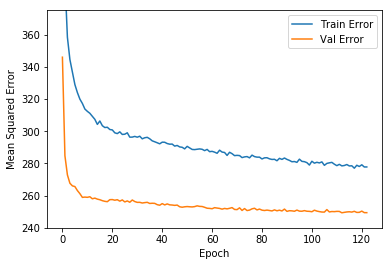

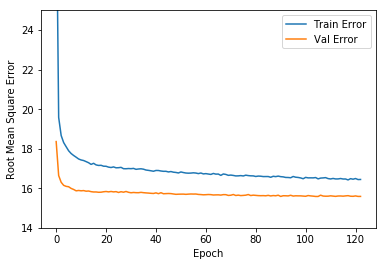

In [44]:
plot_history(history)

In [32]:
loss, mse, rmse = model.evaluate(X_test, y_test, verbose=0)

print("Testing MSE: {:5.2f}".format(mse))
print("Testing RMSE: {:5.2f}".format(rmse))

Testing MSE: 246.91
Testing RMSE: 15.56


In [33]:
y_pred = model.predict(X_test).flatten()

In [34]:
compute_RMSE(y_test, y_pred)

Root mean squared error: 15.711302836903773


Le résultat final est moins bon que celui du XgBoost, mais reste cependant dans le même ordre de grandeur. Nous en déduisons que ce modèle n'est pas le plus adapté pour répondre à la problématique. Ceci n'est pas étonnant dans la mesure où nous n'avons pas un volume de données conséquent pour améliorer l'aprentissage de notre réseau. Un autre point important  est la similarité des jeuxde données de train et d'apprentissage : le réseau apprend paradoxalement mieux sur le jeu d'évaluation que sur le jeu de validation, ce qui peut s'expliquer par la similarité des jeux de données et surtout l'application du drop out. Le réseau dispose de moins de neurones sur la validation, ce qui fait que les résultats sont meilleurs sur le jeu d'eval.

# Export du dataframe sous le bon format

In [35]:
test = pd.read_csv('./input/test.csv')


In [36]:
ratings = pd.DataFrame(y_pred, columns=['Rating']) 

In [37]:
export_df = pd.concat([test[['Artist', 'Track', 'User']].reset_index(drop=True), ratings.reset_index(drop=True), test[['Time']].reset_index(drop=True)], axis=1)

In [38]:
export_df.to_csv('./output/submit.csv')